# Matching Algorithm - Matching Through One Column

##### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re #regular expressions 

##### Read In Data

                                                      M&W Reduced

In [2]:
#pd.set_option('display.max_rows', None)
redFood = pd.read_csv(r"C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\Reduced Super Group\Cleaned\Reduced_SecondClean.csv", index_col=0)
redFood.rename(columns={'Super Group':'SuperGroup'})
redFood['Food Name'] = redFood['Food Name'].str.lower()
redFood.head()

,Food Code,Food Name,Group,Super Group,Sale format(s)
0,17-208,"beer, bitter, best, premium",QA,Alcoholic beverages,"can, can multipack, bottle, bottle multipack"
1,17-224,"cider, sweet",QC,Alcoholic beverages,"can, can multipack, bottle, bottle multipack"
2,17-234,port,QF,Alcoholic beverages,bottle
3,17-236,"sherry, medium",QF,Alcoholic beverages,bottle
4,17-247,"spirits, 40% volume",QK,Alcoholic beverages,"bottle, miniature"


                                                         FPS Data

In [3]:
CleanRetai = pd.read_csv(r'C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\FoodPortionSized\FPS_VJ.csv')
CleanRetai['Food Name'] = CleanRetai['Food Name'].str.lower()
CleanRetai.tail()

,Group,Brand,Food Name,Portion Consumed,Weight,PurEqualCon,Purchased,Format,Source
2672,YOGHURTS AND FROMAGE FRAIS,NaN,onken,NaN,200g,NaN,NaN,NaN,NaN
2673,YOGHURTS AND FROMAGE FRAIS,NaN,petit danoneâ,small,50g,NaN,NaN,NaN,NaN
2674,YOGHURTS AND FROMAGE FRAIS,NaN,st ivel fiendish faces,NaN,50g,NaN,NaN,NaN,NaN
2675,YOGHURTS AND FROMAGE FRAIS,NaN,baby fromage frais,Baby Danone,60g,Y,NaN,NaN,NaN
2676,YOGHURTS AND FROMAGE FRAIS,Heinz,baby fromage frais,Jar,163g,Y,NaN,NaN,NaN


In [4]:
CleanRetail = CleanRetai[CleanRetai['PurEqualCon'].isin(['Y', 'Y, P'])]
CleanRetail.head()

,Group,Brand,Food Name,Portion Consumed,Weight,PurEqualCon,Purchased,Format,Source
0,BABY FOODS,Boots,"first harvest,dessert starter",NaN,125g,Y,NaN,NaN,NaN
1,BABY FOODS,Boots,"first harvest, infant desserts",NaN,125g,Y,NaN,NaN,NaN
2,BABY FOODS,Boots,"first harvest,infant savouries",NaN,125g,Y,NaN,NaN,NaN
3,BABY FOODS,Boots,"first harvest,junior desserts",NaN,190g,Y,NaN,NaN,NaN
4,BABY FOODS,Boots,"first harvest,junior savouries",NaN,190g,Y,NaN,NaN,NaN


###                                                        Match Data.

###### Once matched, Import Weight and Unit Columns into Reduced M&W table

# 1

                                                   Using Fuzzy Matching

In [5]:
%%time
from fuzzywuzzy import fuzz

def match_food_group(CleanRetail, redFood):
    """
    Matches food groups between two DataFrames using fuzzy matching and updates 
    redFood database with Weight and Unit from CleanRetail dataframe.

    Args:
        CleanRetail (DataFrame): The DataFrame containing the clean retail data.
        redFood (DataFrame): The DataFrame containing the red food data.

    Returns:
        DataFrame: The red food DataFrame with updated weight, unit, and super group values.
    """
    # Set a threshold for fuzzy matching.
    threshold = 65

    # Create a set to store the SKU descriptions that have already been matched.
    matched_skus = set()

    # Add Weight and Unit columns to the redFood DataFrame.
    redFood['Weight'] = ''
    redFood['PurEqualCon'] = ''
    redFood['Portion Consumed'] = ''

    # Loop through the rows in the redFood DataFrame.
    for i, row in redFood.iterrows():
        # Get the food name from the current row.
        product = row['Food Name']

        # Check if the food name has already been matched.
        if product in matched_skus:
            continue

        # Check similarity between the food name and SKU descriptions using fuzzy matching.
        matches = CleanRetail['Food Name'].apply(lambda x: fuzz.token_sort_ratio(x, product) >= threshold)

        # Replace NaN values in the boolean Series with False.
        matches = matches.fillna(False)

        # If any match is found, update the 'Weight', 'Unit', and 'Super Group' values in the redFood DataFrame.
        if matches.any():
            match_indices = matches[matches].index
            match_index = match_indices[0]
            food = CleanRetail.loc[match_index, 'Weight']
            unit = CleanRetail.loc[match_index, 'PurEqualCon']
            cons = CleanRetail.loc[match_index, 'Portion Consumed']
            matched_skus.add(product)

            
            redFood.loc[i, 'Weight'] = food
            redFood.loc[i, 'PurEqualCon'] = unit
            redFood.loc[i, 'Portion Consumed'] = cons
            

    return redFood

redFood1 = match_food_group(CleanRetail.copy(), redFood.copy())

CPU times: total: 2.75 s
Wall time: 2.86 s


In [6]:
redFood1['Source'] = ' '

###### Identifying all columns with weights and assigning data source 

In [7]:
pd.set_option('display.max_rows', None)
WeiRdf1 = redFood1.loc[redFood1['Weight'] != '']
WeiRdf1['Source'] = 'FPS'

C:\Users\medekar\AppData\Local\Temp\ipykernel_22888\2909531313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WeiRdf1['Source'] = 'FPS'


###### Updating Red M&W List with Source indications

In [8]:
redFood1.update(WeiRdf1)

In [33]:
a = redFood1.loc[redFood1['Weight'] != '']
a#['Weight'].value_counts().sum()

,Food Code,Food Name,Group,Super Group,Sale format(s),Weight,PurEqualCon,Portion Consumed,Source
6,17-752,"wine, red",QE,Alcoholic beverages,"bottle, small bottle, box",180g,Y,I bottle,FPS
10,17-175,cola,PCA,Beverages,"can, ready to drink bottle, sharing bottle",120g,Y,1 small tub,FPS
11,17-744,cranberry fruit juice drink,PE,Beverages,"carton, tetrapak, bottle",206g,Y,200m1 cartons,FPS
12,17-498,"drinking chocolate, powder",PAA,Beverages,NaN,11g,Y,"1 sachet, average",FPS
13,17-672,"energy drink, carbonated",PCA,Beverages,"can, ready to drink bottle, sharing bottle",250ml,Y,glass bottle,FPS
14,17-745,"grape juice, unsweetened",PE,Beverages,"carton, tetrapak, bottle",12g,"Y, P",1 sachet,FPS
20,17-733,"milk shake, powder",PAA,Beverages,NaN,300g,Y,NaN,FPS
32,11-973,"bread, naan, retail",AF,Cereals and cereal products,"loose, individual\nmultiple pack",160g,Y,NaN,FPS
54,11-799,"biscuits, digestive, plain",AM,Cereals and cereal products,wrapper or box,266g,Y,NaN,FPS
57,11-826,"breadsticks, plain",AM,Cereals and cereal products,box,140g,Y,"each, 7g",FPS


### 97 / 535 items Matched Using Algo 1 

In [10]:
f'First Algorithm Matched {round((97/535) * 100, 2)}% of products between McCane and Widdowson df and Food Portion Sizes df'

'First Algorithm Matched 18.13% of products between McCane and Widdowson df and Food Portion Sizes df'

# 2

                                    Using Term Frequency-Inverse Document Frequency
                                                                        
Its a feature extraction technique used in natural language processing and information retrieval. The main purpose of TfidfVectorizer is to transform a collection of text documents into a numerical feature matrix that can be used as input for machine learning algorithms.

Starts with:

Tokenization: The input text is first split into individual words or tokens.

Term Frequency (TF): For each token, the term frequency is calculated, which represents the number of times a token appears in a specific document.

Inverse Document Frequency (IDF): The inverse document frequency measures how important a word is in the entire collection of documents. If a word appears frequently in many documents, its IDF score will be low. But if a word is rare and only appears in a few documents, its IDF score will be high.

TF-IDF Weighting: The TF-IDF score is calculated for each token in each document by multiplying the term frequency (TF) with the inverse document frequency (IDF)(how unique it is among all the documents).

The result is that words that appear often in a document but are rare overall get a high TF-IDF score.

In [11]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


def match_food_group(CleanRetail, redFood):
    """
    Matches food groups between two DataFrames using TF-IDF and cosine similarity and updates 
    redFood database with Weight and Unit from CleanRetail dataframe.

    Args:
        CleanRetail (DataFrame): The DataFrame containing the clean retail data.
        redFood (DataFrame): The DataFrame containing the red food data.

    Returns:
        DataFrame: The red food DataFrame with updated weight and unit values.
    """
    # Set a threshold for cosine similarity.
    threshold = 0.65

    # Add Weight and Unit columns to the redFood DataFrame.
    redFood['Weight'] = ''
    redFood['PurEqualCon'] = ''
    redFood['Portion Consumed'] = ''

    # Preprocess text data in both DataFrames for the "Food Name" field.
    CleanRetail['Food Name'] = CleanRetail['Food Name'].str.lower()
    redFood['Food Name'] = redFood['Food Name'].str.lower()

    # Create a TF-IDF vectorizer for the "Food Name" field only in the redFood DataFrame.
    vectorizer = TfidfVectorizer()
    vectorizer.fit(CleanRetail['Food Name'])

    # Transform the "Food Name" field into TF-IDF vectors for both DataFrames.
    tfidf_clean_retail = vectorizer.transform(CleanRetail['Food Name'])
    tfidf_red_food = vectorizer.transform(redFood['Food Name'])

    # Loop through the rows in the redFood DataFrame.
    for i, row in redFood.iterrows():
        # Get the food name from the current row.
        product = row['Food Name']

        # Calculate cosine similarity between the food name and all CleanRetail food names.
        similarities = cosine_similarity(tfidf_red_food[i], tfidf_clean_retail)

        # Find the index of the most similar food name based on cosine similarity.
        match_index = similarities.argmax()

        # If the similarity exceeds the threshold, update the 'Weight' and 'PurEqualCon' values in the redFood DataFrame.
        if similarities[0, match_index] >= threshold:
            food = CleanRetail.loc[CleanRetail.index[match_index], 'Weight']
            unit = CleanRetail.loc[CleanRetail.index[match_index], 'PurEqualCon']
            consumed = CleanRetail.loc[CleanRetail.index[match_index], 'Portion Consumed']

            redFood.at[i, 'Weight'] = food
            redFood.at[i, 'PurEqualCon'] = unit
            redFood.at[i, 'Portion Consumed'] = consumed

    return redFood

redFood2 = match_food_group(CleanRetail.copy(), redFood.copy())

CPU times: total: 406 ms
Wall time: 588 ms


In [12]:
redFood2['Source'] = ' '

###### Identifying all columns with weights and assigning data source 

In [13]:
pd.set_option('display.max_rows', None)
WeiRdf2 = redFood2.loc[redFood2['Weight'] != '']
WeiRdf2['Source'] = 'FPS'

C:\Users\medekar\AppData\Local\Temp\ipykernel_22888\1784067148.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WeiRdf2['Source'] = 'FPS'


###### Updating Red M&W List with Source indications

In [14]:
redFood2.update(WeiRdf2)

In [15]:
#redFood2
b = redFood2.loc[redFood2['Weight'] != '']
b.tail()

,Food Code,Food Name,Group,Super Group,Sale format(s),Weight,PurEqualCon,Portion Consumed,Source
482,15-637,"cauliflower cheese, retail",DR,Vegetables,packet,185g,Y,NaN,FPS
487,13-608,"green beans, dried",DI,Vegetables,packet,170g,Y,small can,FPS
500,13-298,"mustard leaves, raw",DG,Vegetables,NaN,5g,Y,I sachet,FPS
504,NaN,"potatoes,",DA,Vegetables,NaN,75g,Y,small,FPS
529,15-617,"sushi, vegetable",DR,Vegetables,NaN,210g/440g,Y,can,FPS


In [16]:
b['Weight'].value_counts().sum()

86

### 86 / 535 items Matched Using Algo 2 

In [17]:
f'Second Algorithm Matched {round((86/535) * 100, 2)}% of products between McCane and Widdowson df and Food Portion Sizes df. Contains some errors'

'Second Algorithm Matched 16.07% of products between McCane and Widdowson df and Food Portion Sizes df. Contains some errors'

# 3

                                               Using Fuzzy Matching



Here, I use fuzz.token_set_ratio from the fuzzywuzzy library to calculate a similarity score between each food name in redFood and all food names in CleanRetail. The token_set_ratio function considers the set of unique tokens (words) in the strings and calculates the similarity based on common token matches. The similarity score ranges from 0 to 100, where higher values indicate more similarity.


By adjusting the threshold value, you can control the matching sensitivity. Lower threshold values will allow for more leniency in matching, potentially catching more variations, while higher threshold values will require closer matches.

In [18]:
%%time
from fuzzywuzzy import fuzz

def match_food_group(CleanRetail, redFood):
    """
    Matches food groups between two DataFrames using approximate string matching and updates 
    redFood database with Weight and Unit from CleanRetail dataframe.

    Args:
        CleanRetail (DataFrame): The DataFrame containing the clean retail data.
        redFood (DataFrame): The DataFrame containing the red food data.

    Returns:
        DataFrame: The red food DataFrame with updated weight and unit values.
    """
    # Set a threshold for string matching similarity.
    threshold = 65  # You can experiment with different threshold values (0 to 100).

    # Add Weight and Unit columns to the redFood DataFrame.
    redFood['Weight'] = ''
    redFood['PurEqualCon'] = ''
    redFood['Portion Consumed'] = ''
    redFood['Source'] = ''

    # Preprocess text data in both DataFrames for the "Food Name" field.
    CleanRetail['Food Name'] = CleanRetail['Food Name'].str.lower()
    redFood['Food Name'] = redFood['Food Name'].str.lower()

    # Loop through the rows in the redFood DataFrame.
    for i, row in redFood.iterrows():
        # Get the food name from the current row.
        product = row['Food Name']

        # Find the most similar food name in CleanRetail using fuzzy string matching.
        best_match = 60
        best_score = 0

        for _, retail_row in CleanRetail.iterrows():
            retail_product = retail_row['Food Name']
            similarity_score = fuzz.partial_token_set_ratio(product, retail_product)

            if similarity_score > best_score and similarity_score >= threshold:
                best_score = similarity_score
                best_match = retail_row

        # If the similarity exceeds the threshold, update the 'Weight' and 'PurEqualCon' values in the redFood DataFrame.
        if best_match is not 60:
            food = best_match['Weight']
            unit = best_match['PurEqualCon']
            consumed = best_match['Portion Consumed']
            sourced = best_match['Source']

            redFood.at[i, 'Weight'] = food
            redFood.at[i, 'PurEqualCon'] = unit
            redFood.at[i, 'Portion Consumed'] = consumed
            redFood.at[i, 'Source'] = sourced

    return redFood

redFood3 = match_food_group(CleanRetail.copy(), redFood.copy())

<timed exec>:46: SyntaxWarning: "is not" with a literal. Did you mean "!="?


CPU times: total: 17 s
Wall time: 17.5 s


                              Creating Source column so I can Identify weight Inputs source

###### Identifying all columns with weights and assigning data source 

In [19]:
pd.set_option('display.max_rows', None)
WeiRdf3 = redFood3.loc[redFood3['Weight'] != '']

WeiRdf3['Source'] = WeiRdf3['Source'].fillna('FPS')

C:\Users\medekar\AppData\Local\Temp\ipykernel_22888\3809329642.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WeiRdf3['Source'] = WeiRdf3['Source'].fillna('FPS')


###### Updating Red M&W List with Source indications

In [20]:
redFood3.update(WeiRdf3)

In [113]:
redFood3.head()

,Food Code,Food Name,Group,Super Group,Sale format(s),Weight,PurEqualCon,Portion Consumed,Source
0,17-208,"beer, bitter, best, premium",QA,Alcoholic beverages,"can, can multipack, bottle, bottle multipack",574g,Y,1 pint,FPS
1,17-224,"cider, sweet",QC,Alcoholic beverages,"can, can multipack, bottle, bottle multipack",300g,Y,NaN,FPS
2,17-234,port,QF,Alcoholic beverages,bottle,161g,Y,"Hot wings, with bones, 5 pieces",FPS
3,17-236,"sherry, medium",QF,Alcoholic beverages,bottle,,,,
4,17-247,"spirits, 40% volume",QK,Alcoholic beverages,"bottle, miniature",29g,Y,1 miniature,FPS


In [117]:
redFood3['Super Group'].unique().tolist()

['Alcoholic beverages',
 'Beverages',
 'Cereals and cereal products',
 'Eggs',
 'Fats and oils',
 'Fish and fish products',
 'Fruit',
 'Herbs and spices',
 'Meat and meat products',
 'Milk and milk products',
 'Nuts and seeds',
 'Soups, sauces and miscellaneous foods',
 'Sugars, preserves and snacks',
 'Vegetables']

In [22]:
c = redFood3.loc[redFood3['Weight'] != '']
c['Food Name'].value_counts().sum()

523

### 523 / 535 items Matched Using Algo 3 

In [26]:
f'Third Algorithm Matched {round((523/535) * 100, 2)}% of products between McCane and Widdowson df and Food Portion Sizes df. Contains some errors'

'Third Algorithm Matched 97.76% of products between McCane and Widdowson df and Food Portion Sizes df. Contains some errors'

Exporting Updated dataframe

In [24]:
redFood3.to_csv(r'C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\ReducedwithWeights\RedM&Weight.csv')

                                            Visualising Matching Efficiency 

In [108]:
# Matched Product Counts.
ax1_count = redFood.groupby('Super Group')['Food Name'].count().rename('Total Prod Count', inplace=True).copy().sort_values(ascending=True)
ax2_count = redFood.groupby('Super Group')['Food Name'].count().rename('Total Prod Count', inplace=True).copy().sort_values(ascending=True)
ax3_count = redFood.groupby('Super Group')['Food Name'].count().rename('Total Prod Count', inplace=True).copy().sort_values(ascending=True)

#Total Product Counts
ax1_s = a.groupby('Super Group')['PurEqualCon'].count().rename('Matched Prod Count', inplace=True).copy().sort_values(ascending=True)
ax2_s = b.groupby('Super Group')['PurEqualCon'].count().rename('Matched Prod Count', inplace=True).copy().sort_values(ascending=True)
ax3_s = c.groupby('Super Group')['PurEqualCon'].count().rename('Matched Prod Count', inplace=True).copy().sort_values(ascending=True)

In [110]:
#
ax1_nt = pd.DataFrame(ax1_count).reset_index()
ax2_nt = pd.DataFrame(ax2_count).reset_index()
ax3_nt = pd.DataFrame(ax3_count).reset_index()

# Find Total Counts of All Categories 
ax1 = pd.DataFrame(ax1_s).reset_index()
ax2 = pd.DataFrame(ax2_s).reset_index()
ax3 = pd.DataFrame(ax3_s).reset_index()

# Evaluating Percentaged Mapped
ax1_counts = ax1_nt.merge(ax1, on='Super Group', how='left')
ax1_counts['%Matched'] = ax1_counts['Matched Prod Count'] / ax1_counts['Total Prod Count'] * 100 

ax2_counts = ax2_nt.merge(ax2, on='Super Group', how='left')
ax2_counts['%Matched'] = ax2_counts['Matched Prod Count'] / ax2_counts['Total Prod Count'] * 100 

ax3_counts = ax3_nt.merge(ax3, on='Super Group', how='left')
ax3_counts['%Matched'] = ax3_counts['Matched Prod Count'] / ax3_counts['Total Prod Count'] * 100 

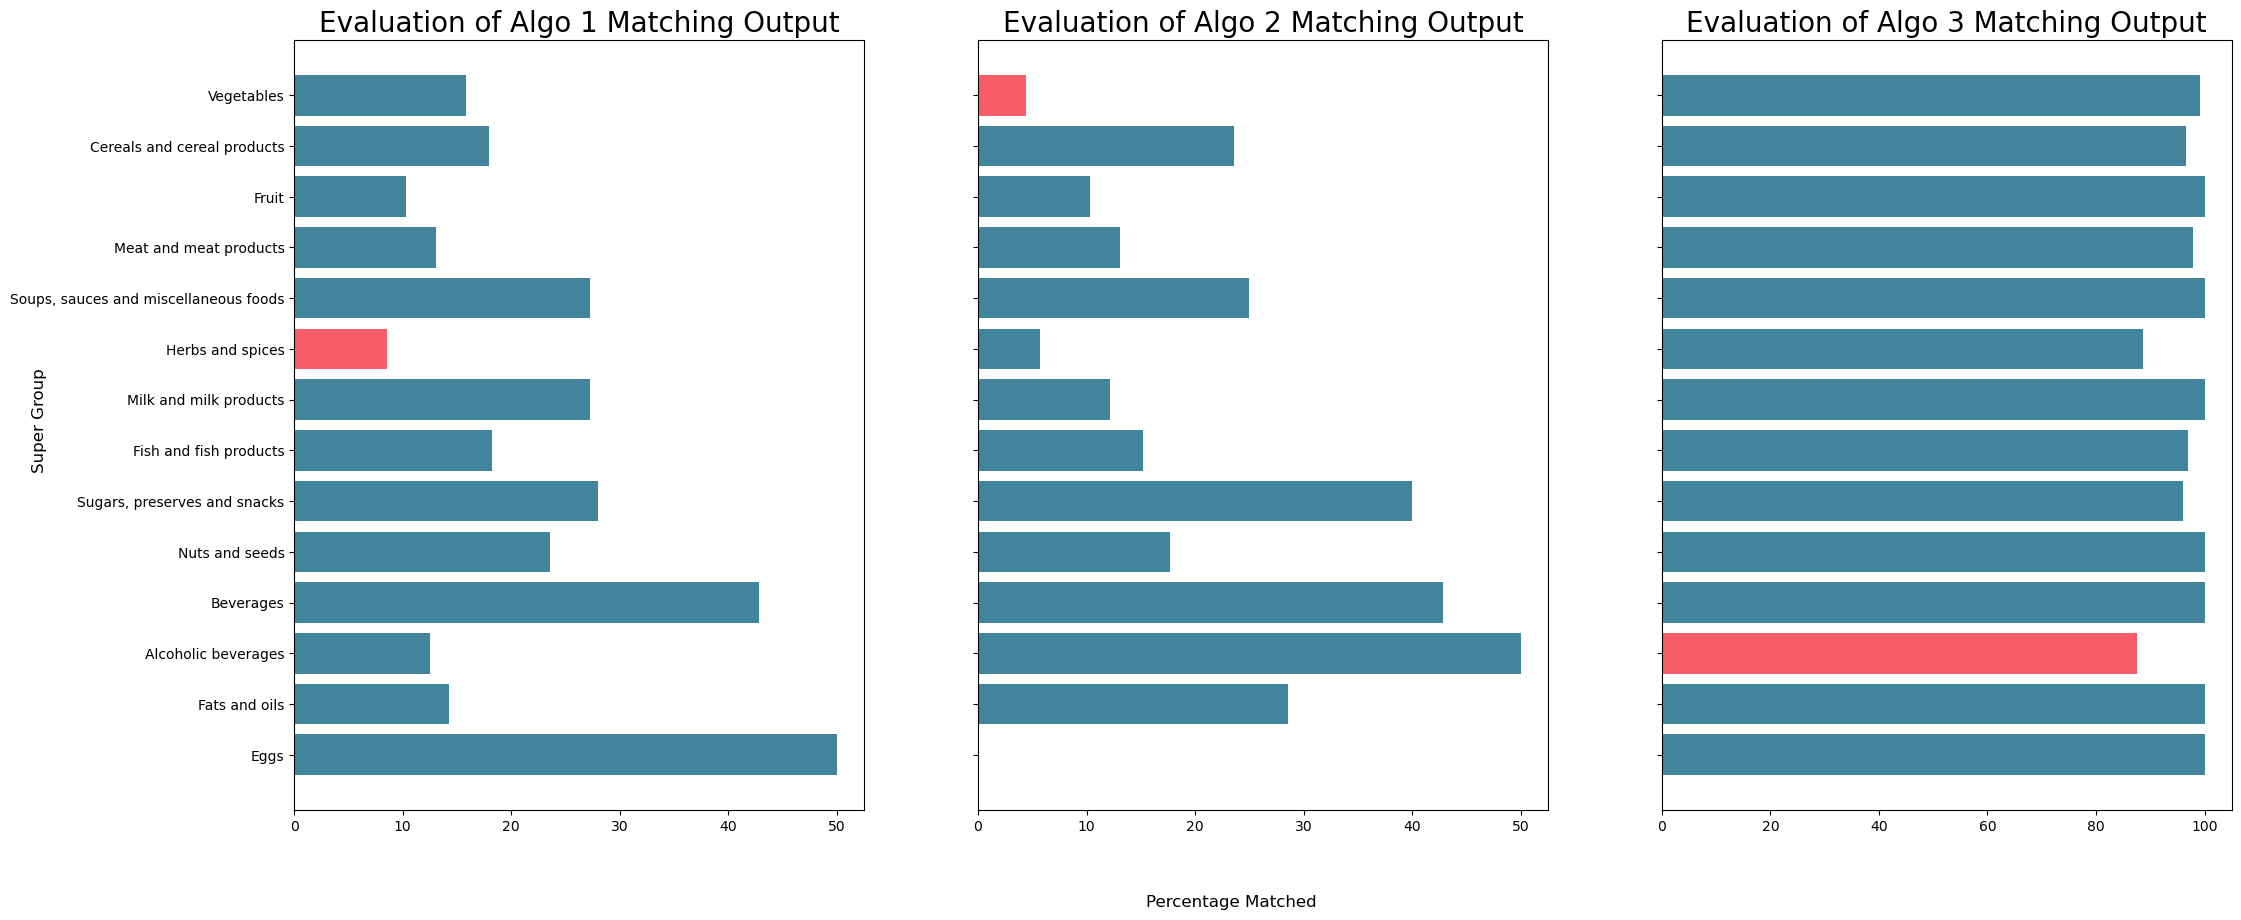

In [116]:
# Find the minimum count in each grouped DataFrame.
min_count1 = ax1_counts['%Matched'].min()
min_count2 = ax2_counts['%Matched'].min()
min_count3 = ax3_counts['%Matched'].min()

# Create a list of colors for the bars. If count equals the minimum count, set the color to red; otherwise, set it to teal.
bar_colors1 = ['#f95d6a' if count == min_count1 else '#42849B' for count in ax1_counts['%Matched']]
bar_colors2 = ['#f95d6a' if count == min_count2 else '#42849B' for count in ax2_counts['%Matched']]
bar_colors3 = ['#f95d6a' if count == min_count3 else '#42849B' for count in ax3_counts['%Matched']]

# Create a figure with three subplots (1 row, 3 columns) for each algorithm's matching output evaluation.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=True)
fig.set_size_inches(25, 10)

# Plot the bar chart for each algorithm's matching output evaluation.
ax1.barh(ax1_counts['Super Group'], ax1_counts['%Matched'], color=bar_colors1)
ax1.set_title('Evaluation of Algo 1 Matching Output', fontsize=20)

ax2.barh(ax2_counts['Super Group'], ax2_counts['%Matched'], color=bar_colors2)
ax2.set_title('Evaluation of Algo 2 Matching Output', fontsize=20)

ax3.barh(ax3_counts['Super Group'], ax3_counts['%Matched'], color=bar_colors3)
ax3.set_title('Evaluation of Algo 3 Matching Output', fontsize=20)

# Set the label for the common x-axis and y-axis of the subplots.
fig.supxlabel("Percentage Matched")
fig.supylabel("Super Group")

plt.show()

### Algo 3 most successful with Matching but contains errors. Evaluate Success rate of Matching. 

                                                  NEXT NOTEBOOK